### Part 2: Poetry generation (for real)

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
!pip install pytorch-lightning torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 13.8 MB/s eta 0:00:00


In [2]:
import string
import os

import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from random import sample

import pytorch_lightning as pl
from torch.utils.data import DataLoader

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [4]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join([x.lower() for x in text])

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


### Data loading: "Евгений Онегин"


In [6]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2024-12-07 17:02:47--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2024-12-07 17:02:47 (10.0 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(x.replace('\t\t', '').lower() for x in text)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [8]:
tokens = sorted(set(text)) + ['|']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [9]:
# dict <index>:<char>
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

In [10]:
def matrix(data, max_len=None, pad=token_to_idx['|'], dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, data))
    data_ix = np.full((len(data), max_len), fill_value=pad, dtype=dtype)

    for i, line in enumerate(data):
        data_ix[i, :len(line)] = [token_to_idx[c] for c in line]

    return data_ix if batch_first else data_ix.T

train_dataset = [x for x in text.split('\n') if len(x) > 10]

In [13]:
print(f"Dataset Summary")
print(f"----------------")
print(f"Total samples in train dataset: {len(train_dataset)}")
print()

print(f"First 10 samples:")
print("------------------------------------------------------------")
for i, sample in enumerate(train_dataset[:10], 1):
    print(f"{i}: {sample}")

Dataset Summary
----------------
Total samples in train dataset: 5254

First 10 samples:
------------------------------------------------------------
1: «мой дядя самых честных правил,
2: когда не в шутку занемог,
3: он уважать себя заставил
4: и лучше выдумать не мог.
5: его пример другим наука;
6: но, боже мой, какая скука
7: с больным сидеть и день и ночь,
8: не отходя ни шагу прочь!
9: какое низкое коварство
10: полуживого забавлять,


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

Plot the loss function (axis X: number of epochs, axis Y: loss function).

**Комментарий:**

Поскольку я использовал PyTorch Lightning, интерактивные TensorBoard логи занимают достаточно много места. Поэтому ниже прилагаю скриншоты графиков лосса.

In [14]:
class CharRNN(pl.LightningModule):
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=256, max_length=100):
        super().__init__()
        self.num_units = rnn_num_units
        self.num_tokens = num_tokens
        self.max_length = max_length

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = torch.tanh(self.rnn_update(x_and_h))
        logits = self.rnn_to_logits(h_next)
        return h_next, F.log_softmax(logits, dim=-1)

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=self.device)

    def rnn_loop(self, batch_ix):
        batch_size, max_length = batch_ix.size()
        hid_state = self.initial_state(batch_size)
        logprobs = []

        for x_t in batch_ix.transpose(0, 1):
            hid_state, logp_next = self(x_t, hid_state)
            logprobs.append(logp_next)

        return torch.stack(logprobs, dim=1)

    def training_step(self, batch, batch_idx):
        batch_ix = batch
        logp_seq = self.rnn_loop(batch_ix)
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]
        loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None]))
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def generate_sample(self, seed_phrase=' ', max_length=None, temperature=1.0):
        max_length = max_length if max_length else self.max_length
        x_sequence = [token_to_idx[token.lower()] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=self.device)
        hid_state = self.initial_state(batch_size=1)

        for i in range(len(seed_phrase) - 1):
            hid_state, _ = self(x_sequence[:, i], hid_state)

        for _ in range(max_length - len(seed_phrase)):
            hid_state, logp_next = self(x_sequence[:, -1], hid_state)
            p_next = F.softmax(logp_next / temperature, dim=-1).cpu().data.numpy()[0]
            next_ix = np.random.choice(self.num_tokens, p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=self.device)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

        return ''.join([idx_to_token[ix] for ix in x_sequence.cpu().data.numpy()[0]]).split('|')[0]

In [15]:
def collate_fn(batch):
    return torch.tensor(matrix(batch), dtype=torch.int64)

In [16]:
num_iter = 4000
batch_size = 32
steps_per_epoch = len(train_dataset) // batch_size
num_epochs = num_iter // steps_per_epoch

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
char_rnn = CharRNN(max_length=max(map(len, train_dataset)))

In [18]:
trainer = pl.Trainer(max_epochs=num_epochs, log_every_n_steps=10)
trainer.fit(char_rnn, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type      | Params | Mode 
----------------------------------------------------
0 | embedding     | Embedding | 5.4 K  | train
1 | rnn_update    | Linear    | 82.2 K | train
2 | rnn_to_logits | Linear    | 21.6 K | train
----------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.437     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


In [40]:
# Интерактивный просмотр логов
#%reload_ext tensorboard
#%tensorboard --logdir=lightning_logs/

In [20]:
# An example of generated text.
print("=" * 50)
print("Generated Text Samples")
print("=" * 50)

for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"\nTemperature: {t:.1f}")
    print("-" * 50)
    for i in range(3):
        generated_text = char_rnn.generate_sample(temperature=t)
        print(f"Sample {i + 1}: {generated_text}")
    print("-" * 50)

Generated Text Samples

Temperature: 0.1
--------------------------------------------------
Sample 1:  нему надежды не старины,
Sample 2:  нему надежды не своей
Sample 3:  нему надежды не старины
--------------------------------------------------

Temperature: 0.2
--------------------------------------------------
Sample 1:  на вольной старый вам,
Sample 2:  пладимая страсти не старинный,
Sample 3:  ней сердце в сердце венеренья,
--------------------------------------------------

Temperature: 0.5
--------------------------------------------------
Sample 1:  над первый пламенным снегов
Sample 2:  отремется в судьбой страсти небовал
Sample 3:  не полуж и печальный
--------------------------------------------------

Temperature: 1.0
--------------------------------------------------
Sample 1:  нидезлон мои ум, рины.
Sample 2:  долодила ностиный?
Sample 3:  ней любовью, томит чужны,
--------------------------------------------------

Temperature: 2.0
--------------------------------------

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

*Comment: if you wish, you can use small GPT as well (e.g. from https://github.com/karpathy/nanoGPT)*

Plot the loss function of the number of epochs. Does the final loss become better?

In [33]:
class CharRNNLoop(pl.LightningModule):
    def __init__(self, num_tokens=len(tokens), emb_size=64, rnn_num_units=256):
        super().__init__()
        self.num_tokens = num_tokens
        self.MAX_LENGTH = None
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.rnn_num_units = rnn_num_units

    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

    def training_step(self, batch, batch_idx):
        # Calculate log probabilities
        batch_ix = batch
        logp_seq = self(batch_ix)

        # Calculate loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]
        loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None]))

        # Log the loss
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def generate_sample(self, seed_phrase=' ', max_length=None, temperature=1.0):
      assert self.MAX_LENGTH, "You should fit model before generating sample"
      max_length = max_length if max_length else self.MAX_LENGTH

      device = next(self.parameters()).device

      x_sequence = [token_to_idx[token.lower()] for token in seed_phrase]
      x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=device)

      for _ in range(max_length - len(seed_phrase)):
          logp_next = self(x_sequence[:, :])
          p_next = F.softmax(logp_next / temperature, dim=-1).detach().cpu().numpy()[0]
          next_ix = np.random.choice(self.num_tokens, p=p_next[-1, :])
          next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
          x_sequence = torch.cat([x_sequence, next_ix], dim=1)

      return ''.join([tokens[ix] for ix in x_sequence.detach().cpu().numpy()[0]]).split('|')[0]

In [26]:
#char_rnn_loop = CharRNNLoop()
#char_rnn_loop.fit(train_dataset, num_iter=4000, plot_loss=True)

In [34]:
import glob

checkpoint_path = sorted(glob.glob('/content/lightning_logs/version_*/checkpoints/*.ckpt'))[-1]
print(f"Loading checkpoint from: {checkpoint_path}")

Loading checkpoint from: /content/lightning_logs/version_1/checkpoints/epoch=3999-step=660000.ckpt


In [35]:
# Загрузить модель из контрольной точки
char_rnn_loop = CharRNNLoop.load_from_checkpoint(checkpoint_path)
char_rnn_loop.MAX_LENGTH = max(map(len, train_dataset))

In [38]:
# Интерактивный просмотр логов
#%reload_ext tensorboard
#%tensorboard --logdir=lightning_logs/

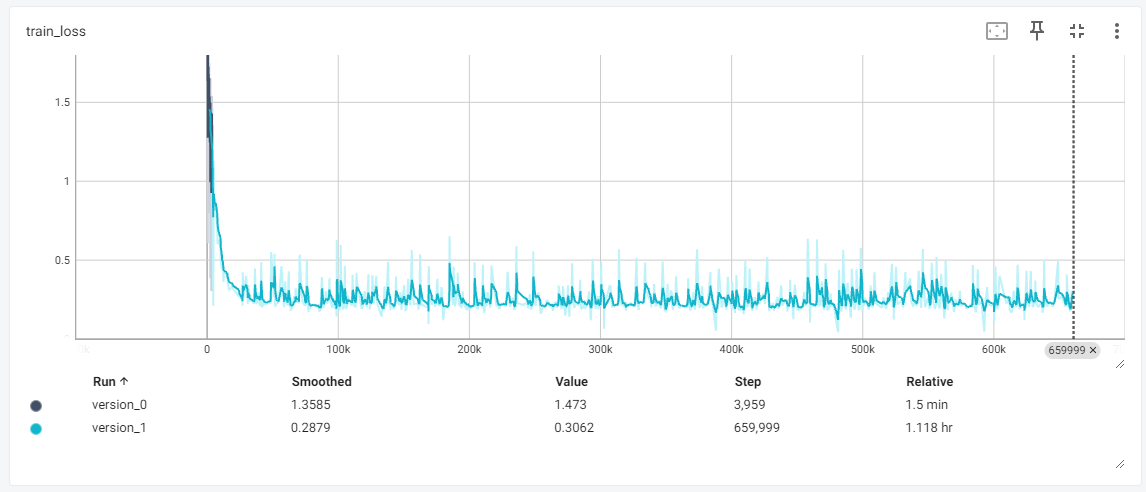

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [37]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"temperature = {t}:")
    for _ in range(3):
        print('\t', char_rnn_loop.generate_sample(temperature=t))

temperature = 0.1:
	  что ж? что парьма?» – «так же чептра,
	  что ж? что парьма?» – «так же чептра,
	  что ж? что парьма?» – «так же чептра,
temperature = 0.2:
	  что ж? что как в деревне страстей,
	  что ж? что парьма?» – «так же чептра,
	  что ж? что парьма?» – «так же чептра,
temperature = 0.5:
	  что ж? что выражала нара
	  что ж? что как в деревне страстей,
	  что ж? что как в душе ночный.
temperature = 1.0:
	  что-то с нею гонитель.
	  что ж? аслужу это сплосно
	  где плыток я перед рой.
temperature = 2.0:
	  укаблось… когда нет.
	  начнем ненаводит он
	  что жизни перелит.


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [39]:
torch.save(char_rnn_loop, 'model')
model = torch.load('model')
model.generate_sample(temperature=0.5)

<ipython-input-39-93e2a7194bf6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model')


' что ж? что выраться давно,'

**Выводы:**

Чем ниже значение температуры, тем чаще модель выбирает наиболее популярные и предсказуемые комбинации символов, создавая текст, который кажется более осмысленным, но менее разнообразным. При повышении температуры увеличивается вероятность выбора менее популярных символов, что делает текст более разнообразным, но при этом он теряет связность и становится менее логичным.

Оптимальное значение температуры, которое обеспечивает баланс между смыслом и разнообразием текста, обычно находится в районе 0.5. Это позволяет генерировать текст, который выглядит естественно и в то же время сохраняет элемент творческой вариативности.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)
4. nanoGPT by Andrej Karpathy: https://github.com/karpathy/nanoGPT